In [1]:
from importlib import reload
import sys
import os
sys.path.insert(0, './../scripts')

In [2]:
import pickle
import numpy as np
import scipy
import torch
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.figure import figaspect
import time

import base_network as base_net
import ring_network as network
import sim_util as su
import ricciardi as ric
import integrate as integ

def imshowbar(fig,ax,A,**kwargs):
    imsh = ax.imshow(A,**kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(imsh, cax=cax, orientation='vertical')
    return cbar

# Build Ring Network, Get Input Stats

In [66]:
prms = {}
prms['K'] = 500
prms['J'] = 1e-3*10**(np.arange(0,8+1)/8 - 1)[-1]
prms['gE'] = 8
prms['gI'] = 3
prms['beta'] = 1
prms['hE'] = 3
prms['hI'] = 0.5
prms['L'] = 20
prms['CVL'] = 2.154434690031884#2.15
prms['SoriE'] = 30
prms['SoriI'] = 25
prms['SoriF'] = 25

CVh = np.sqrt((0.2+1)/500)
cA = 2
rX = 30/(1+cA)

N = 6250
Nori = 1
NE = 4*(N//Nori)//5
NI = 1*(N//Nori)//5

prms['Nori'] = Nori
prms['NE'] = NE
prms['NI'] = NI

prms['basefrac'] = 1

In [67]:
prms['J']*prms['K']*prms['hE']*rX*(1+cA)

45.0

In [77]:
net,this_M,this_H,this_B,this_LAS,this_EPS = su.gen_ring_disorder_tensor(1,prms,CVh)
M = this_M.cpu().numpy()
H = (rX*(this_B+cA*this_H)*this_EPS).cpu().numpy()
LAS = this_LAS.cpu().numpy()

Using cpu


(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0., 1250.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.]),
 array([-0.5       , -0.44999999, -0.40000001, -0.34999999, -0.30000001,
        -0.25      , -0.2       , -0.15000001, -0.1       , -0.05      ,
         0.        ,  0.05      ,  0.1       ,  0.15000001,  0.2       ,
         0.25      ,  0.30000001,  0.34999999,  0.40000001,  0.44999999,
         0.5       ]),
 <BarContainer object of 20 artists>)

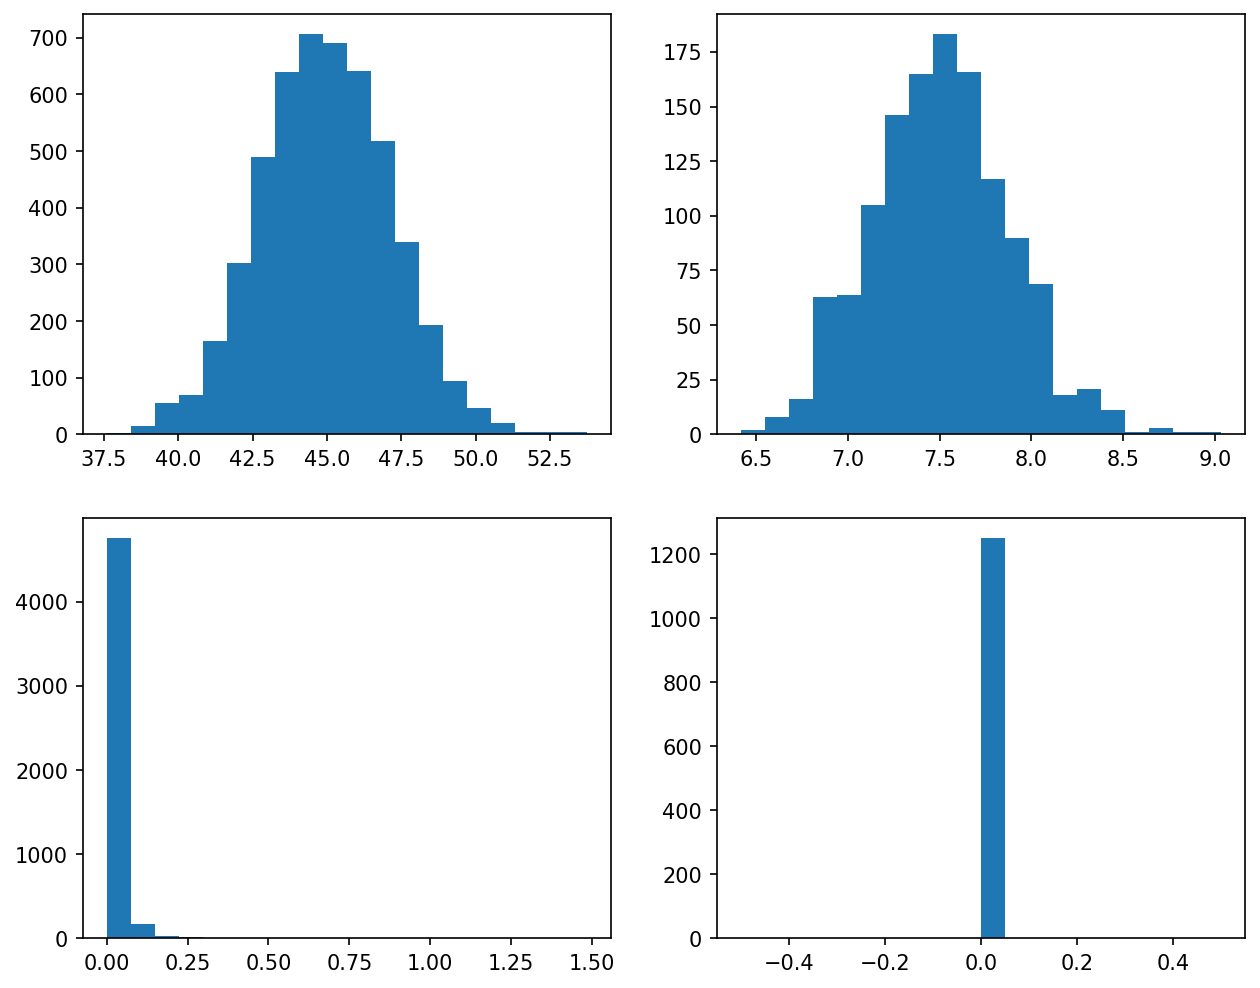

In [78]:
fig,axs = plt.subplots(2,2,figsize=(10,8),dpi=150)

axs[0,0].hist(H[net.C_all[0]],20)
axs[0,1].hist(H[net.C_all[1]],20)
axs[1,0].hist(LAS[net.C_all[0]],20)
axs[1,1].hist(LAS[net.C_all[1]],20)

# Build Ale's Unstructured Network, Get Input Stats

In [27]:
resh_dir = './../../../Reshuffling/2-SuppFigures/Supp_Figure_2/simulations/simulations_fixed_gs'

sys.path.insert(0, resh_dir)

import functions as fun

import pandas as pd

In [56]:
sigma_Lambda_over_Lambda

2.154434690031884

In [29]:
pdf = pd.read_csv(resh_dir+'/simulation_param.txt',delim_whitespace=True) #header=None
jn = 19689

g_E=pdf.g_E.iloc[jn]; 
g_I=pdf.g_I.iloc[jn]; 
beta=pdf.beta.iloc[jn]; 
K=int(pdf.K.iloc[jn]); 
sigma_Lambda_over_Lambda=pdf.sigma_Lambda_over_Lambda.iloc[jn]; 
J=pdf.J.iloc[jn]; 
r_X=pdf.r_X.iloc[jn];
ell=pdf.ell.iloc[jn];

p=0.1; 
sigma_X_over_r_X=0.2; 
Lambda=1*10**-3; 
sigma_Lambda=sigma_Lambda_over_Lambda*Lambda

G_E,G_I=1.0,2.0 # Gain of Excitatory and inhibitory cells and I cells
w_EE=1;w_IE=w_EE/beta;
w_EI=g_E*w_EE;w_II=g_I*w_IE;
w_EX,w_IX=(G_I*fun.gamma*g_E-G_E)*w_EE,(G_I*fun.gamma*g_I-G_E)*w_IE; 
w_X=np.asarray([w_EX,w_IX]);
w=np.zeros((2,2));
w[0,:]=w_EE,-w_EI
w[1,:]=w_IE,-w_II

M,mu_X_over_r_X_tau,Lambda_i,N_E,N_I=fun.Generate_quenched_disorder(sigma_X_over_r_X,J,K,w,w_X,p,Lambda,sigma_Lambda)

In [36]:
J*K*r_X*3

44.96131877392057

(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0., 1250.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.]),
 array([-0.5 , -0.45, -0.4 , -0.35, -0.3 , -0.25, -0.2 , -0.15, -0.1 ,
        -0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,
         0.4 ,  0.45,  0.5 ]),
 <BarContainer object of 20 artists>)

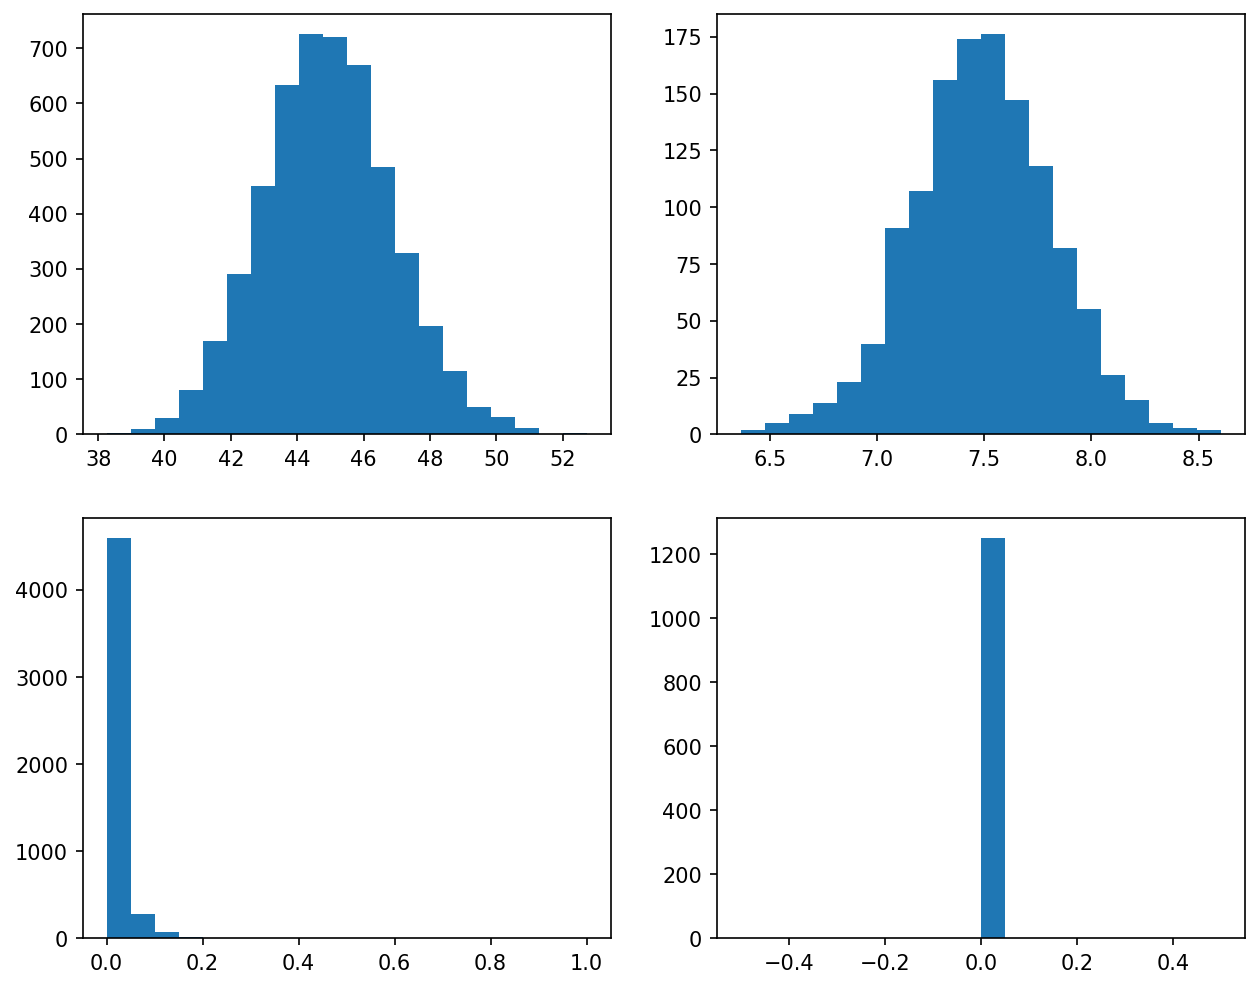

In [37]:
fig,axs = plt.subplots(2,2,figsize=(10,8),dpi=150)

axs[0,0].hist(mu_X_over_r_X_tau[:5000]*r_X,20)
axs[0,1].hist(mu_X_over_r_X_tau[5000:]*r_X,20)
axs[1,0].hist(Lambda_i[:5000]*ell,20)
axs[1,1].hist(Lambda_i[5000:]*ell,20)

In [76]:
print(np.mean(Lambda_i[:5000]*ell))
print(np.std(Lambda_i[:5000]*ell))
print(np.std(Lambda_i[:5000]*ell)/np.mean(Lambda_i[:5000]*ell))

0.01948021600185061
0.04464424778778774
2.2917737556681383


In [79]:
print(np.mean(LAS[net.C_all[0]]))
print(np.std(LAS[net.C_all[0]]))
print(np.std(LAS[net.C_all[0]])/np.mean(LAS[net.C_all[0]]))

0.02035795
0.05011095
2.461493
